In [117]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [118]:
df = pd.read_excel('data/Report_21_050718_3.xls')

In [119]:
df_demographics = pd.read_excel('data/Proteomics-Subjects_Wcodes.xlsx')

In [120]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df_demographics.columns = df_demographics.columns.str.replace(' ','_').str.lower()

In [121]:
'''
Converting long data to wide data
There are 12 subjects per group with 2 different dosages and total of 3 groups for 72 rows. 
We first identify the 72 columns, iterate through them and create one row per that item using pivot.
'''
out = pd.DataFrame()
for i in list(df.columns[((df.columns.str.endswith('_1') | df.columns.str.endswith('_2')))]):
    pat_info = i.split('_')
    df['pat_id'] = pat_info[0][1:]
    row = df.pivot(index='pat_id', columns='uniprot_id', values=i)
    row['dt_start'] = pat_info[1]
    row['dt_end'] = pat_info[2]
    row['dose']  = pat_info[3][:-2]
    row['group']  = pat_info[0][0]
    out = out.append(row)
out = out.replace(np.nan,0)

##### Fix Types

In [122]:
out['dose'] = out['dose'].astype('int64', copy=False)

In [123]:
out = out.replace(0,np.nan)

In [124]:
out.index = out.index.astype('int64')
df_demographics.set_index('id',inplace=True)
out = out.join(df_demographics)

In [125]:
numeric_cols = out.loc[:,out.dtypes =='float64']
numeric_cols = np.log(numeric_cols)
non_numeric_cols = out.loc[:,~(out.dtypes =='float64')]
out = pd.concat([numeric_cols,non_numeric_cols], axis=1)

In [126]:
data = out

In [127]:
data = data.drop(['group','gr','sex'], axis=1)

In [128]:
data.suicide.replace(to_replace=['Non-Suic', 'Suicide'], value=[0, 1], inplace=True)
data_y = data['suicide']
data_x = data.drop(['suicide','dt_start','dt_end'], axis = 1)

# Use random forest to identify important features

In [134]:
import warnings
from xgboost import XGBClassifier

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb = XGBClassifier(n_estimators=100,max_depth = 5 , class_weight="balanced", random_state=100)
    xgb.fit(data_x,data_y)

In [135]:
importances = xgb.feature_importances_

In [136]:
indices = np.argsort(importances)[::-1]

df_list = []

for f in range(data_x.shape[1]):
    df_list.append([list(data_x.columns)[indices[f]], importances[indices[f]]])
    
feature_rank = pd.DataFrame(df_list)
feature_rank = feature_rank.rename(columns={0:'feature',1:'importance'})

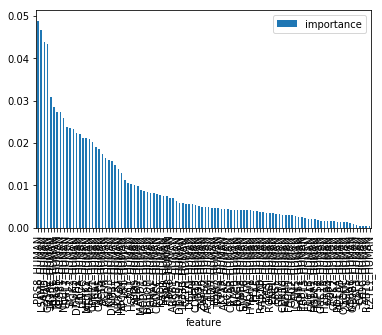

In [137]:
feature_rank[feature_rank['importance']>0].plot.bar(x='feature', y='importance', rot=90)

# Visualize the distribution of the most important feature identified by Random Forest

ATD3A_HUMAN


C:\Users\James\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


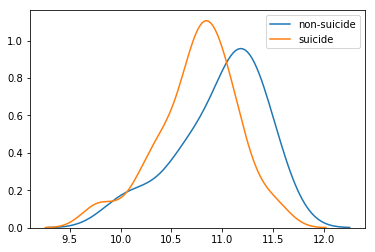

In [136]:
feature1 = feature_rank.iloc[0]['feature']
print(feature1)
sns.kdeplot(data[(data['suicide']==0)]['FGF9_HUMAN'],label='non-suicide')
sns.kdeplot(data[(data['suicide']==1)]['FGF9_HUMAN'],label='suicide')

# Run t-test to see which features are statistically significant between two groups

In [138]:
import scipy 

In [139]:
from scipy import stats

pvalues = []
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        p = scipy.stats.mannwhitneyu(data[data['suicide']==0][feature], data[data['suicide']==1][feature], use_continuity=True, alternative=None)[1]
        pvalues.append([feature,p])

pvalues = pd.DataFrame(pvalues)
pvalues = pvalues.rename(columns={0:'feature',1:'pvalues'})

In [181]:
scipy.stats.mannwhitneyu(data[data['suicide']==0][feature], data[data['suicide']==1][feature], use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=431.0, pvalue=0.007770977240719859)

### Using Boneferroni adjustments

In [140]:
pvalues[pvalues['pvalues']<0.05/100]

,feature,pvalues
0,PRS8_HUMAN,0.000273
16,ATD3A_HUMAN,0.000067
17,CPNE1_HUMAN,0.000380


### Using Benjamini–Hochberg procedure, with 5% false positive rate

In [170]:
pvalues['rank'] = np.argsort(pvalues.pvalues).argsort()+1

In [176]:
pvalues[pvalues['pvalues'] < pvalues['rank']/100*.05]

,feature,pvalues,rank
0,PRS8_HUMAN,0.000273,2
6,TBA4B_HUMAN,0.003570,11
11,PGK2_HUMAN,0.002714,10
16,ATD3A_HUMAN,0.000067,1
17,CPNE1_HUMAN,0.000380,3
22,KAD3_HUMAN,0.000841,5
30,SBDS_HUMAN,0.001373,7
49,CDK13_HUMAN,0.001976,8
51,ZNF76_HUMAN,0.000980,6
73,ENPL_HUMAN,0.000640,4


### Effect Size Comparisons between Depressed vs Suicide and Nondepressed vs Suicide

### Depressed vs Suicide

In [211]:
data = out
data.suicide.replace(to_replace=['Non-Suic', 'Suicide'], value=[0, 1], inplace=True)

In [196]:
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [234]:
cohen_dvs = []
data = out 
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        res = cohend(data[data['group']=='c'][feature], data[data['suicide']==1][feature])
        cohen_dvs.append([feature,res])

cohen_dvs = pd.DataFrame(cohen_dvs)
cohen_dvs = cohen_dvs.rename(columns={0:'feature',1:'cohend'})

In [235]:
cohen_dvns = []
data = out 
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        res = cohend(data[data['group']!='c'][feature], data[data['suicide']==1][feature])
        cohen_dvns.append([feature,res])

cohen_dvns = pd.DataFrame(cohen_dvns)
cohen_dvns = cohen_dvns.rename(columns={0:'feature',1:'cohend'})

### Largest Differences by Cohen's D

In [245]:
cohen_dvns['feature'][np.argsort(-(np.abs(cohen_dvs['cohend'] - cohen_dvns['cohend'])))]

49    CDK13_HUMAN
36     GNAL_HUMAN
63    CPNE8_HUMAN
16    ATD3A_HUMAN
0      PRS8_HUMAN
29    HS71L_HUMAN
69    RA51D_HUMAN
93    PDE8A_HUMAN
68     ITA6_HUMAN
17    CPNE1_HUMAN
73     ENPL_HUMAN
66    HYOU1_HUMAN
8     NECP1_HUMAN
75     GRB2_HUMAN
54      BDH_HUMAN
11     PGK2_HUMAN
51    ZNF76_HUMAN
15    METK2_HUMAN
23    DNM1L_HUMAN
6     TBA4B_HUMAN
85    SNTA1_HUMAN
22     KAD3_HUMAN
94    AL1A3_HUMAN
55     PSA7_HUMAN
35    PGRC1_HUMAN
5      OXR1_HUMAN
20     ACTA_HUMAN
30     SBDS_HUMAN
50      QOR_HUMAN
44    DDX17_HUMAN
         ...     
48     PERI_HUMAN
58    AL1A2_HUMAN
98    OTUB1_HUMAN
12    DDAH2_HUMAN
26    HECAM_HUMAN
86    HSP72_HUMAN
74     6PGL_HUMAN
80    ICAM5_HUMAN
47    DC1I1_HUMAN
72    ROGDI_HUMAN
34    DBLOH_HUMAN
42    ARRB1_HUMAN
21     ACPM_HUMAN
41     TBA8_HUMAN
97    KS6A6_HUMAN
33    CCDC6_HUMAN
39     ETFD_HUMAN
9     TRI17_HUMAN
45    1433B_HUMAN
24     HPRT_HUMAN
56    TRIM2_HUMAN
61     KAP0_HUMAN
96     ASNS_HUMAN
53    ACTBM_HUMAN
87    NIPS

### Summary
Log adjustment to data
fill 0s by group, sex
nonparametric test - mann whiteney u. Can only be used for ordinal data(larger is significant) For each observation in one set, count the number of times this first value wins over any observation.
Boneferroni correction since we are making lots of tests. Picked 100 most important features.
4 were significant
ATD3A_HUMAN	0.000067
CPNE1_HUMAN	0.000380
PRS8_HUMAN	0.000273
SYFA_HUMAN	0.000084